In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

import random

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def create_random_policy(nA): #这个应该是 bahaviour policy
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [4]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    #off-policy的PI和on-policy的策略基本一致，就是去掉了随机性，永远选argmax_a(Q(x,a))
    def policy_fn(observation): #observation 就是 state
        actions = Q[observation]

        best_action = np.argmax(actions)
        return best_action
#         prob = np.zeros_like(actions)
#         prob[best_action] = 1.0

#         #check probs sum to 1
#         assert np.sum(prob) == 1.0
        
#         return prob
        # Implement this!
    return policy_fn

In [5]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    init_fn = lambda: np.zeros(env.action_space.n)
    Q = defaultdict(init_fn)
    C = defaultdict(init_fn) #对于weighted重要性采样, C存放的是 sum{W}
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    # Implement this!
    
    for i_episode in range(num_episodes):
        #进度条
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        state_actions = [] #在 bahavior policy上采样的 (state, action) 序列
        B_probs = [] # behavior policy 在 B(x,a) 的概率
        
        observation = env.reset()
        
        #first-visit policy evalution
        #compute average of Q(x,a)
        for t in range(100):
            action_probs = behavior_policy(observation) # \pi(x)
            #                 sampled_action = random.choices(list(range(1,nA + 1)), action_probs)

            sampled_action = random.choices([0,1], action_probs)[0] #random.choices 返回的是一个数组
#             actions_cnt[sampled_action] += 1
            #             print("sampled_action is ", sampled_action)
            #             print("Taking action: {}".format( ["Stick", "Hit"][action]))

            #记录每次遇到的 (state, action) 以及 B(x,a)
            state_actions.append((observation, sampled_action))
            B_probs.append(action_probs[sampled_action])
            observation, reward, done, _ = env.step(sampled_action)

            if done:
                assert len(state_actions) == t + 1
                assert len(B_probs) == t + 1
            #                 print_observation(observation)
            #                 print("Game end. Reward: {}\n".format(float(reward)))

                R_B = reward #reward of behavior policy
                W = 1.0
#                 sum_weight = 0.0
                #虽然这里是 first-visit，但是对于21点，不会重复访问同一个state
                #所以这里省略了判断first visit
                for i_step in range(t, -1, -1): #backward
            #                     print(i)
                    state, behavior_policy_action = state_actions[i_step]
#                     R_B = 
                    #不能放在后面
                    R_B = discount_factor * R_B
                    target_policy_action = target_policy(state)
                    
                    weight_numerator = 1.0 if behavior_policy_action == target_policy_action else 0.0
                    weight_denominator = B_probs[i_step]
                    assert weight_denominator != 0
                    W *= weight_numerator / weight_denominator
                    
                    if W == 0: 
                        break #go to next episode
                    
                    R_PI = W * R_B
                    
                    Q[state][behavior_policy_action] = ( Q[state][behavior_policy_action] * C[state][behavior_policy_action] + R_PI) / (C[state][behavior_policy_action] + W) 
                    C[state][behavior_policy_action] += W
#                     if behavior_policy_action != target_policy_action:
                     
                    
    
        
#                     returns_sum[state][action] += G
#                     returns_count[state][action] += 1
            
                    #2. empirical Q(x,a) =  (\sum Q(x,a)) /count(x,a)
                    #加速了大概10倍的样子
#                     Q[state][action] = returns_sum[state][action] / returns_count[state][action]
            
                    
                    
                break
        
        
    return Q, target_policy

In [6]:
# random_policy = create_random_policy(env.action_space.n)
# Q, policy = mc_control_importance_sampling(env, num_episodes=5000, behavior_policy=random_policy)

In [7]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=2900000, behavior_policy=random_policy)

Episode 2899000/2900000.

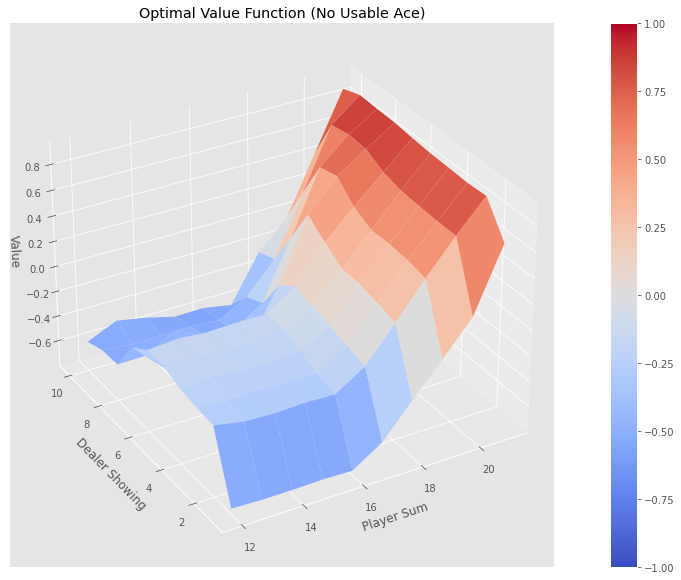

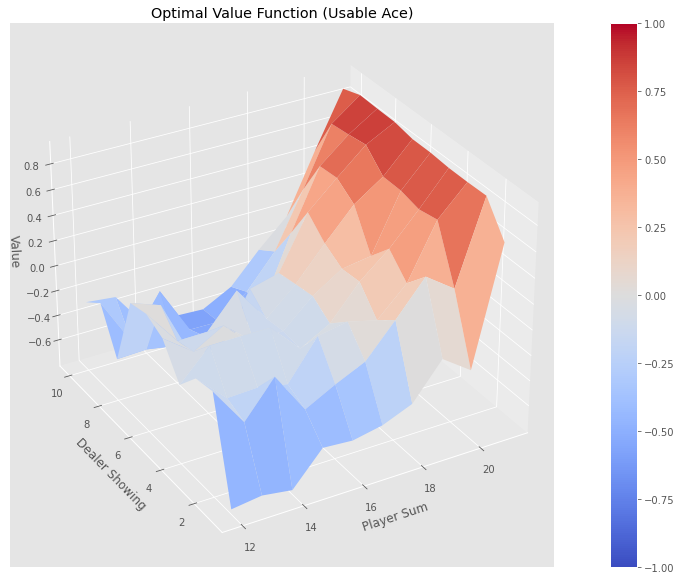

In [8]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")